Anuragh Sundar

# Classifying NBA Stats by Era

In this lab I will go through K-Means and Expectation-Maximization (Gaussian Mixture Model). I will be doing unsupervised learning as that is what these techniques are used for but I do have the true labels to check the accuracy of my algorithms

In [54]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [55]:
pip install scipy

  Using cached numpy-1.22.4-cp38-cp38-macosx_10_15_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
Note: you may need to restart the kernel to use updated packages.


In [56]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


We will set up our plotting enviornment

In [57]:
import numpy as np 
import pickle
import os
from numpy.random import default_rng
from scipy.stats import norm

rng = default_rng(seed=12345)

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# colors used 
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
RED = '#B00805'
FIG_WIDTH = 4
FIG_HEIGHT = 3


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.serif": ["Palatino"],
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 3
})

Now we will import our data. We import a CSV file and then search for the criteria that we want met and extract. Once we have done that we create a dictionary with our features,samples and labels. Remember the labels are only used to check

In [58]:
import pandas as pd


# load the CSV file into a pandas dataframe
df = pd.read_csv('pstats.csv')

# select rows where Season is between 1980 and 1990 and drop any rows with missing data
# add minute treshold to filter data
df80s = df[(df['Season'] >= 1980) & (df['Season'] < 1990) &(df['MP'] > 1500) ].dropna()

#query for positional trends
#df80s = df.query('Season >= 1980 & Season < 1990 & MP > 1500 & Pos in ["G","PG","G-F","F-G", "SG"]').dropna()

# select 200 random player seasons from the 80s
np.random.seed(123)  # set random seed for reproducibility
random_80s = np.random.choice(df80s.index, size=200, replace=False)
df80s = df80s.loc[random_80s]

# select rows where Season is between 2000 and 2010 and drop any rows with missing data
df2000s = df[(df['Season'] >= 2000) & (df['Season'] < 2010) & (df['MP'] > 1500)].dropna()

#query for positional trends
#df2000s = df.query('Season >= 2000 & Season < 2010 & MP > 1500 & Pos in ["G","PG","G-F","F-G","SG"]').dropna()

# select 200 random player seasons from the 2000s
np.random.seed(456)  # set random seed for reproducibility
random_2000s = np.random.choice(df2000s.index, size=200, replace=False)
df2000s = df2000s.loc[random_2000s]

# select rows where Season is between 2010 and 2020 and drop any rows with missing data
df2010s = df[(df['Season'] >= 2013) & (df['MP'] > 1500)].dropna() #started from 2013 to better differentiate data

#query for positional trends
#df2010s = df.query('Season >= 2015 & MP > 1500 & Pos in ["G","PG","G-F","F-G","SG"]').dropna()

# select 200 random player seasons from the 2010s
np.random.seed(789)  # set random seed for reproducibility
random_2010s = np.random.choice(df2010s.index, size=200, replace=False)
df2010s = df2010s.loc[random_2010s]

# combine the three dataframes into one
combined = pd.concat([df80s, df2000s, df2010s])
combined_shuffled = combined.sample(frac=1, random_state=42)

# select the columns you want to keep
t_keys = ['FGA', '3PA', '2PA', 'FTA', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
keys = ['FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 'eFG%', 'FTA', 'FT%', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
df_all = combined_shuffled[keys + ['Player', 'Season','MP']]
for tk in t_keys: #get per game stats
    df_all[tk] = df_all[tk]/df_all['MP']

# create the NBA dictionary
NBA = {'keys': keys,
       'stats': df_all[keys].to_numpy(),
       'era': []}

for index, row in combined_shuffled.iterrows():
    if row['Season'] >= 1980 and row['Season'] < 1990:
        NBA['era'].append(1980)
    elif row['Season'] >= 2000 and row['Season'] < 2010:
        NBA['era'].append(2000)
    elif row['Season'] >= 2013:
        NBA['era'].append(2010)



print('These are the features of each data sample: \n\n',NBA['keys'])
print('\nThis is your dataset shape:\n\n',NBA['stats'].shape)
print('\nThis is how your labels look:\n\n',NBA['era'][0:10])


These are the features of each data sample: 

 ['FGA', 'FG%', '3PA', '3P%', '2PA', '2P%', 'eFG%', 'FTA', 'FT%', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

This is your dataset shape:

 (600, 17)

This is how your labels look:

 [1980, 2010, 2010, 1980, 1980, 2000, 1980, 2010, 1980, 2000]


<ipython-input-58-dbaf97e643d3>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all[tk] = df_all[tk]/df_all['MP']


We will color our data for the plots

In [59]:
colors = np.array([ORANGE,TEAL,GREEN])
eras = np.array([1980,2000,2010])
cmap = []
for e in NBA['era']:
    cmap.append(colors[np.argwhere(e == eras).item()])

We will normalize our data so that we can start our K-Means

In [60]:
def normalize(x):
    '''
    Normalizes the input data
    '''
    new_x = np.zeros_like(x)
    for col in range(x.shape[1]):
        new_x[:,col] = (x[:,col]-x[:,col].mean())/x[:,col].std()
    return new_x

stats = normalize(NBA['stats'])


Our keys again:

In [61]:
for i in range(len(NBA['keys'])):
    print('%d: '%i,NBA['keys'][i])


0:  FGA
1:  FG%
2:  3PA
3:  3P%
4:  2PA
5:  2P%
6:  eFG%
7:  FTA
8:  FT%
9:  DRB
10:  TRB
11:  AST
12:  STL
13:  BLK
14:  TOV
15:  PF
16:  PTS


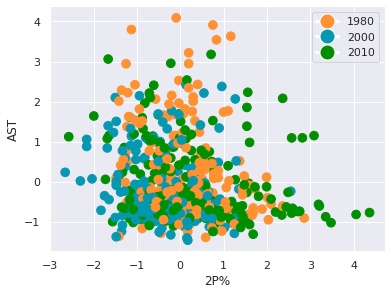

In [62]:
from matplotlib.lines import Line2D
def init_plot(x_var, y_var):
# chose the axes for each feature


    fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH*1.5,FIG_HEIGHT*1.5))
    # we can now use the colormap we defined
    axs.scatter(stats[:,x_var],stats[:,y_var],c=cmap,s=75)
    legend_elements = [Line2D([0],[0],marker='o',color='w',label=eras[i],
                            markerfacecolor=colors[i], markersize=15) for i in range (len(eras))]
    axs.legend(handles=legend_elements)
    axs.set_xlabel(NBA['keys'][x_var])
    axs.set_ylabel(NBA['keys'][y_var])
    plt.show()

init_plot(5,11)

When comparing AST to 2P% we see little distinciton between the eras. Lets now try this with different categories.

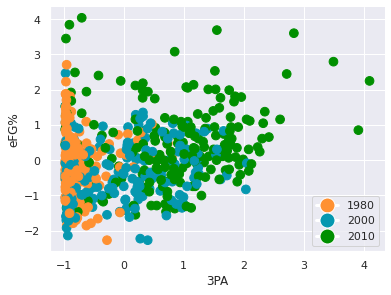

In [63]:
init_plot(2,6)

Here we can see a more clear distinction of the eras with different features selected. Though 2000 vs 2010 still seems hard to guage. We will see how well our algorithms do with that.

Now we will start our KMeans 

In [64]:
def Centroid_init(X, K):
    """
    Given training data X, this function initializes K different centroids
    Inputs:
        X - Data as np.array of dim: Nx(# features)
        K - Number of centroids
    
    Outputs:
        m - np.array of cluster centers, dimL Kx(# features)
    """
    # Hint, zeros are not a good initialization, I just made it so the whole notebook will run
    # Get the number of samples and number of features
    N, D = X.shape
    
    # Initialize the centroid matrix with zeros
    m = np.zeros((K, D))
    
    # Randomly select K samples as the initial centroids
    random_idx = np.random.choice(N, size=K, replace=False)
    m = X[random_idx, :]
    '''try: 
        m = np.zeros((K,X.shape[1]))
    except:
        m = np.zeros(K)'''
    return m

In [65]:
m = Centroid_init(stats,len(eras))
print(m)

[[-2.81114842e+00 -3.52419912e-01 -9.72031351e-01 -1.91218630e+00
  -1.80599763e+00 -8.16215173e-01 -1.15495626e+00 -1.44335858e+00
  -7.83485761e-02 -7.13957154e-01 -1.43059784e-01 -7.24275820e-01
   2.44673607e+00 -6.00397867e-01 -2.19417461e+00  5.85677769e-01
  -2.60089200e+00]
 [-1.22519212e+00 -4.54265567e-01  1.53231577e+00  9.78724551e-01
  -2.13130183e+00  8.97496012e-01  2.00632090e+00 -1.43225690e+00
   1.17093557e+00 -8.95781568e-01 -1.09489690e+00 -7.18414392e-01
  -1.49803719e+00 -5.22161080e-01 -1.57440022e+00 -1.01030882e-01
  -9.57227862e-01]
 [-2.55059708e-01  5.03083584e-01 -8.26226739e-01 -3.85841642e-01
   3.43335173e-01  1.74846717e-01 -1.73870244e-01  1.50346995e+00
  -8.25343220e-01  2.62296914e-01  4.33190524e-01 -1.09317433e+00
  -7.88368714e-01 -1.44249960e-03 -6.86346035e-01 -4.04491125e-02
   1.44845361e-01]]


In [66]:
def Set(X, m):
    '''
    Now we define a function that creates the sets of data points closest
    to each centroid. Also it is useful to compute the distortion.
    Inputs:
        X - Data as np.array of dim: Nx(# features)
        m - np.array of cluster centers, dimL Kx(# features)
    
    Outputs:
        C - The sets for each cluster. There should be K sets inside C, 
            but you can play around with how you define C. I suggest using a 
            dict and storing the actual datapoints such that when you call
            C['i'], you get an np.array() of dim: Mx(# features), where M can vary in size.
            This is useful as np.arrays can not have varying length rows...
            
        D - Distortion as defined. This can just be a floating point.
    '''
    C = {}
    Distortion = 0
    
    for i in range(X.shape[0]):
        # Find the closest centroid
        closest_idx = np.argmin(np.sum((m - X[i])**2, axis=1))
        # Assign the data point to the closest centroid's cluster
        if closest_idx not in C:
            C[closest_idx] = []
        C[closest_idx].append(X[i])
        # Update the distortion
        Distortion += np.sum((X[i] - m[closest_idx])**2)
    for k in C.keys():
        C[k] = np.array(C[k])
    
    return (C, Distortion)

In [67]:
C, D = Set(stats,m)
for key in C:
    print('centroid %d: '%key, C[key].shape)
print('\nTotal Distortion: %.3f'%D)

centroid 2:  (452, 17)
centroid 1:  (118, 17)
centroid 0:  (30, 17)

Total Distortion: 12400.784


In [68]:
def Update(X, C, m):
    '''
    This is step 3), where we update our cluster centers.
    If you followed the structure from before this step should 
    be very simple as C['i'] will store the entire set of datapoints
    associated with cluster i.

    Inputs:
        X - Data as np.array of dim: Nx(# features)
        C - Dictionary of sets corresponding to ea cluster
        m - np.array of cluster centers, dimL Kx(# features)
    
    Outputs:
        m - np.array of NEW cluster centers, dimL Kx(# features)
    
    HINT: Cluster centers can be empty if initialized poorly, so be careful
    '''
    '''try: 
        m = np.zeros((m.shape[0],X.shape[1]))
    except:
        m = np.zeros(m.shape[0])'''
    for k in C.keys():
        m[k] = np.mean(C[k], axis=0)
    
    return m


In [69]:
m = Update(stats,C,m)
print(m)


[[-1.41912634 -0.7862824  -0.41724356 -0.27095548 -0.96218766 -0.8829742
  -1.08010303 -0.79438537 -0.21272175 -0.60887899 -0.58054207  0.49436709
   1.37498696 -0.35079817 -0.6688977   0.48074491 -1.48222255]
 [-0.43252967 -0.4729085   1.13360303  0.78666478 -1.15969831  0.05761305
   0.71280241 -0.95287102  0.54967702 -0.50697209 -0.66719645 -0.21562544
  -0.32191571 -0.443897   -0.89842987 -0.58675058 -0.42619167]
 [ 0.20710684  0.1756453  -0.26824746 -0.18738447  0.36661511  0.04356391
  -0.11439733  0.30148306 -0.12938105  0.17276344  0.21271116  0.02347962
  -0.00722025  0.13916768  0.27894172  0.1212704   0.20964003]]


In [70]:
def K_Means(X, K):
    '''
    Now put it all together. 

    Inputs:
        X - Data as np.array of dim: Nx(# features)
        K - Number of centroids
    
    Outputs
        m - np.array of FINAL cluster centers, dimL Kx(# features)
        D - The final distortion
    '''
    '''try: 
        m = np.zeros((K,X.shape[1]))
    except:
        m = np.zeros(K)'''
    D = 0

    cent = Centroid_init(X, K)
    D_prev = None
    for i in range(1000):
        C, D = Set(X, cent)
        cent = Update(X, C, cent)
        if D_prev is not None and abs(D - D_prev) < 1e-5: #convergence
            break
        D_prev = D

    print("DONE")
    return(cent, D)

In [71]:
m, D = K_Means(stats, len(eras))

DONE


In [72]:

era_count = np.zeros((len(eras),len(eras)))
for idx in range(stats.shape[0]):
    distance = np.linalg.norm((stats[idx]-m),axis=1)**2
    centroid = np.argmin(distance)
    temp_era = NBA['era'][idx]
    era_count[centroid][np.argwhere(temp_era == eras).item()] += 1

print('\t',end="")
for e in eras:
    print(e,'\t',end="")
print('\n')
for i in range(era_count.shape[0]):
    print('K = %d \t'%i,end="")
    for j in range(era_count.shape[1]):
        print(str(int(era_count[i,j]))+'\t',end="")
    print("\n")

	1980 	2000 	2010 	

K = 0 	15	102	118	

K = 1 	77	64	39	

K = 2 	108	34	43	



Overall, we can see that our K-means algorithm did not do a good job of labeling the data. This could show that the NBA really hasn't changed as much as is commonly percived. We should also consider factors like positions, games played and minutes played. I put a treshold on minutes played to only consider quality players, but that did not seem to change much. I also adjusted the 2010's era to 2013 - present to both consider the modern game and hope for more seperation in the data but again it did not change much. Finally I adjusted for position but unfortunalety our data still did not change much. I tried to see if any position in particular changed throughout the eras but no such seperation occured. I would also like to see if we can distingush one position from another based on the players stas.

In [73]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Now we will do our EM algorithim. 

### EM Algorithm
 
Here are the general steps to write an EM algorithm our stats dataset using a Gaussian mixture model:

Initialize the model parameters:
 - The number of mixture components K (in our case 3).
 - The mixing coefficients pi, which are the probabilities of each mixture component. 
 - The means mu and covariances sigma of each mixture component.

E-step: Calculate the responsibilities of each mixture component for each data point. This involves computing the probability density function (PDF) of each mixture component for each data point, and then computing the posterior probabilities of each mixture component using Bayes' theorem and the mixing coefficients.

M-step: Update the model parameters using the responsibilities calculated in E step:

 - Update the mixing coefficients pi using the average responsibilities of each component.
 - Update the means mu of each component using the weighted average of the data points, where the weights are the responsibilities of each component.
 - Update the covariances sigma of each component using the weighted average of the squared distances of the data points from the means, where the weights are the responsibilities of each component.

Repeat steps 2 and 3 until convergence, which is typically defined by a maximum number of iterations or a threshold for the change in the log-likelihood of the data.

For simplicities sake I will write down an example for an EM algorithm ![EM Equation](gmmwork.png)

This work shows what an EM algorthim would look like for a varying sigma^2.

Here we will use a built in EM model for our data:

In [74]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3)
gmm.fit(stats)
labels = gmm.predict(stats)
# Define the label dictionary
label_dict = {1980: 0, 2000: 1, 2010: 2}

# Convert the true labels to integer values
true_labels = np.array([label_dict[label] for label in NBA['era']])

# Compare the predicted labels to the true labels
accuracy = np.mean(labels == true_labels)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.13


We can see even the EM algorithm wasn't very accurate and thus can conclude that NBA eras are not seperable purely based on statistics.

Below is an extra class I created that could be used instead of the built in one. It used KMeans and some other Sklearn functions. 

In [75]:

class GaussianMixture:
    def __init__(self, n_components=3, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        
    def initialize_parameters(self, X):
        # Initialize means using K-means clustering
        kmeans = KMeans(n_clusters=self.n_components).fit(X) #from sklearn (our use the one we created earlier)
        self.means = kmeans.cluster_centers_

        # Initialize covariances to be diagonal matrices with equal variance
        var = np.var(X, axis=0)
        self.covs = np.array([np.diag(var)] * self.n_components)

        # Initialize mixture coefficients to be equal
        self.weights = np.ones(self.n_components) / self.n_components

    def compute_likelihood(self, X):
        likelihood = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            likelihood[:, k] = multivariate_normal.pdf(X, self.means[k], self.covs[k]) #from sklearn
        return likelihood
    
    def compute_posterior(self, X):
        likelihood = self.compute_likelihood(X)
        posterior = likelihood * self.weights
        posterior /= np.sum(posterior, axis=1, keepdims=True)
        return posterior
    
    def update_parameters(self, X, posterior):
        n_samples = X.shape[0]
        self.weights = np.mean(posterior, axis=0)

        for k in range(self.n_components):
            # Update means
            self.means[k] = np.sum(posterior[:, k].reshape(n_samples, 1) * X, axis=0) / np.sum(posterior[:, k])

            # Update covariances
            diff = X - self.means[k]
            self.covs[k] = (posterior[:, k].reshape(n_samples, 1) * diff).T @ diff / np.sum(posterior[:, k])

    def fit(self, X):
        self.initialize_parameters(X)

        for i in range(self.max_iter):
            # E-step: Compute posterior probabilities
            posterior = self.compute_posterior(X)

            # M-step: Update parameters
            self.update_parameters(X, posterior)

            # Compute log-likelihood
            log_likelihood = np.sum(np.log(np.sum(posterior * self.weights, axis=1)))

            # Check for convergence
            if i > 0 and np.abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
                
            prev_log_likelihood = log_likelihood
